# Survival Analysis Practical Session
### TP: Kaplan–Meier and Cox Proportional Hazards Model (Python)

This notebook demonstrates a complete workflow for survival analysis:
1. Load and explore a survival dataset.
2. Estimate survival using the Kaplan–Meier estimator.
3. Compare survival curves with the log-rank test.
4. Fit and interpret a Cox proportional hazards model.
5. Evaluate model performance and compare with Kaplan–Meier.

Dataset used: **Lung Cancer Dataset** from `lifelines`.

In [1]:
# --- 1. Import required packages ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from lifelines.datasets import load_lung
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index

plt.style.use('seaborn-v0_8')

In [2]:
from sksurv.util import Surv
from sksurv.metrics import brier_score

## 1. Load and Explore the Dataset

In [3]:
# Load the built-in lung cancer dataset
df = pd.read_csv('./lung_dataset.csv')

# Set as binary variables
df["status"] = df["status"].apply(lambda x: 1 if x == 2 else 0)
df["sex"] = df["sex"].apply(lambda x: 1 if x == 2 else 0)


print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (228, 11)


,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,cig
0,3.0,306,1,74,0,1.0,90.0,100.0,1175.0,NaN,0.0
1,3.0,455,1,68,0,0.0,90.0,90.0,1225.0,15.0,1.0
2,3.0,1010,0,56,0,0.0,90.0,90.0,NaN,15.0,1.0
3,5.0,210,1,57,0,1.0,90.0,60.0,1150.0,11.0,1.0
4,1.0,883,1,60,0,0.0,100.0,90.0,NaN,0.0,1.0


In [4]:
# Descriptive statistics
df.describe(include='all').round(2)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,cig
count,227.00,228.00,228.00,228.00,228.00,227.00,227.00,225.00,181.00,214.00,228.00
mean,11.09,305.23,0.72,62.45,0.39,0.95,81.94,79.96,928.78,9.83,1.39
std,8.30,210.65,0.45,9.07,0.49,0.72,12.33,14.62,402.17,13.14,2.99
min,1.00,5.00,0.00,39.00,0.00,0.00,50.00,30.00,96.00,-24.00,0.00
25%,3.00,166.75,0.00,56.00,0.00,0.00,75.00,70.00,635.00,0.00,0.00
50%,11.00,255.50,1.00,63.00,0.00,1.00,80.00,80.00,975.00,7.00,1.00
75%,16.00,396.50,1.00,69.00,1.00,1.00,90.00,90.00,1150.00,15.75,1.00
max,33.00,1022.00,1.00,82.00,1.00,3.00,100.00,100.00,2600.00,68.00,19.00


In [5]:
print(f"Number of smokers with cig >= 1: {(df['cig'] >= 1).sum()}")

Number of smokers with cig >= 1: 146


We have the following key columns:
- `time`: follow-up duration (days)
- `status`: event indicator (1 = death, 0 = censored)
- covariates such as `age`, `sex`, `ph.ecog`, etc.

### Description of the `lung_dataset.csv` dataset

| Variable       | Type               | Description                                                                 | Notes / Typical values |
|----------------|--------------------|------------------------------------------------------------------------------|-------------------------|
| **inst**       | Integer            | Institution code (hospital or treatment center)                              | Values between 1 and 12 |
| **time**       | Float            | Survival or follow-up time (in days)                                         | Main duration variable `T_i` |
| **status**     | Integer (binary)   | Event indicator: `1 = death`, `0 = censored`                                | Recoded from original {1 = censored, 2 = death} |
| **age**        | Float            | Patient age (in years)                                                      | Mean around 60 years |
| **sex**        | Integer (binary)   | Patient sex: `1 = female`, `0 = male`                                       | Recoded from original {1 = male, 2 = female} |
| **ph.ecog**    | Integer            | ECOG performance score (Eastern Cooperative Oncology Group)                 | 0 = asymptomatic, 1 = restricted but active, 2 = bed <50%, 3 = bed >50% |
| **ph.karno**   | Integer            | Karnofsky performance score (physician-rated)                               | Range 0 (dead) to 100 (perfect health) |
| **pat.karno**  | Integer            | Karnofsky performance score (patient self-rated)                            | Same scale as `ph.karno` |
| **meal.cal**   | Integer            | Average meal caloric intake                                                 | Nutritional indicator, sometimes missing |
| **wt.loss**    | Float            | Weight loss over the last 6 months (in pounds)                              | Clinical indicator of health decline |
| **cig** | Integer | Average number of cigarettes smoked per week | Synthetic variable inversely related to survival time; higher values indicate heavier smoking |

Source: https://cran.r-project.org/web/packages/survival/survival.pdf

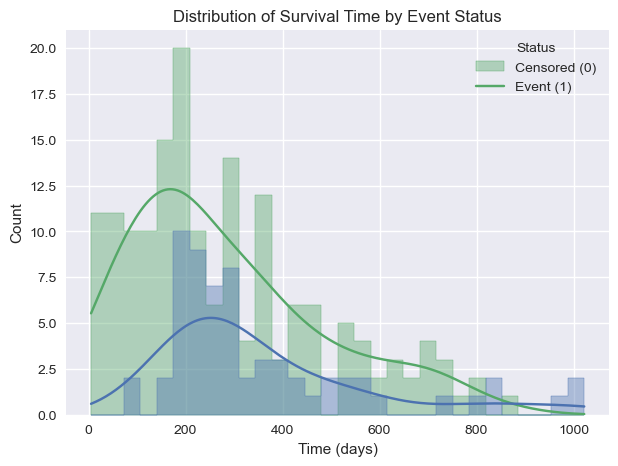

In [6]:
plt.figure(figsize=(7,5))
sns.histplot(data=df, x="time", hue="status", bins=30, kde=True, element="step", alpha=0.4)
plt.title("Distribution of Survival Time by Event Status")
plt.xlabel("Time (days)")
plt.ylabel("Count")
plt.legend(title="Status", labels=["Censored (0)", "Event (1)"])
plt.show()

## 2. Kaplan–Meier Estimation

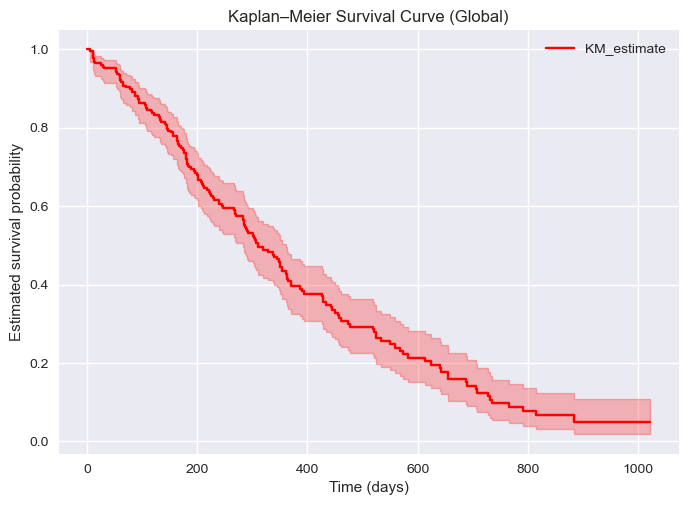

In [7]:
# Kaplan-Meier estimation for the whole population
kmf = KaplanMeierFitter()
kmf.fit(df["time"], event_observed=df["status"])

kmf.plot_survival_function(ci_show=True, color="red")
plt.title("Kaplan–Meier Survival Curve (Global)")
plt.xlabel("Time (days)")
plt.ylabel("Estimated survival probability")
plt.show()

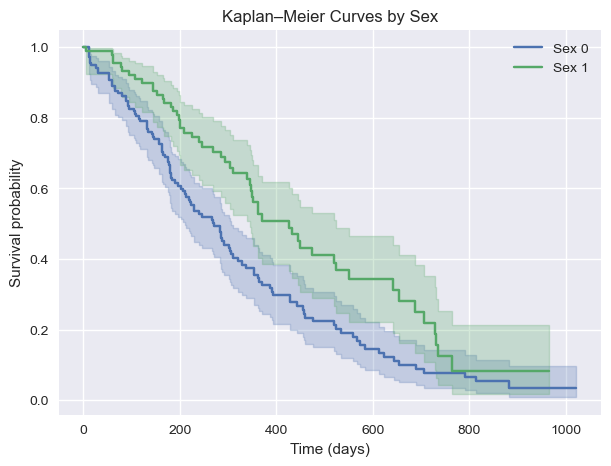

In [8]:
# Kaplan-Meier by sex
plt.figure(figsize=(7,5))
for sex, group in df.groupby("sex"):
    kmf.fit(group["time"], event_observed=group["status"], label=f"Sex {sex}")
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Curves by Sex")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

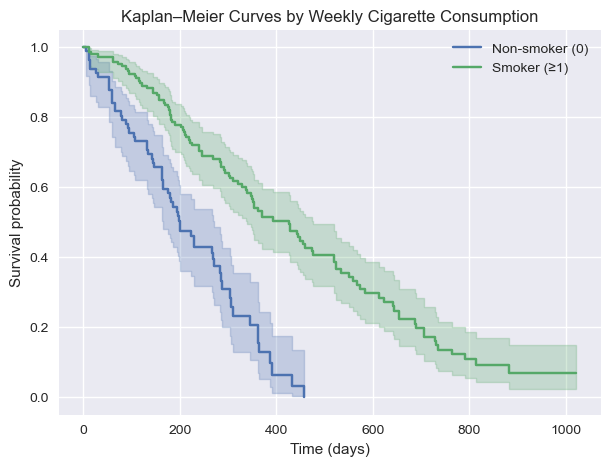

In [9]:
# Group cigarettes into two categories: non-smokers (0) vs smokers (≥1)
df["cig_group"] = df["cig"].apply(lambda x: "Non-smoker (0)" if x == 0 else "Smoker (≥1)")

# Kaplan–Meier by cigarette group
plt.figure(figsize=(7,5))
for cig_group, group in df.groupby("cig_group"):
    kmf.fit(group["time"], event_observed=group["status"], label=cig_group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Curves by Weekly Cigarette Consumption")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

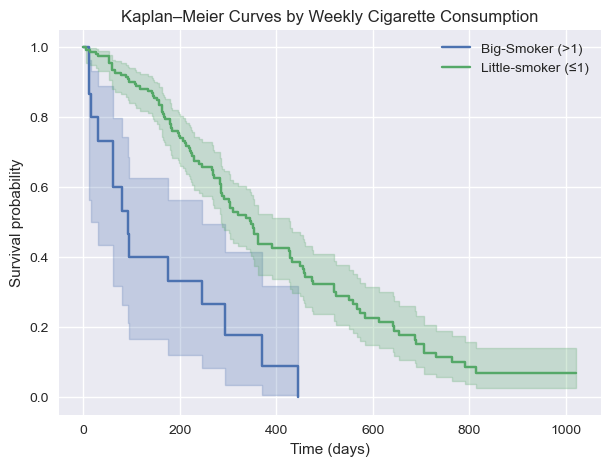

In [36]:
# Group cigarettes into two categories: non-smokers (0) vs smokers (≥1)
df["cig_group"] = df["cig"].apply(lambda x: "Little-smoker (≤1)" if x <= 1 else "Big-Smoker (>1)")

# Kaplan–Meier by cigarette group
plt.figure(figsize=(7,5))
for cig_group, group in df.groupby("cig_group"):
    kmf.fit(group["time"], event_observed=group["status"], label=cig_group)
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Curves by Weekly Cigarette Consumption")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.legend()
plt.show()

### Log-Rank Test
We now test whether the two survival curves (males vs females) are statistically different using the log-rank test.

In [11]:
# Log-rank test between sexes
results = logrank_test(
    df.loc[df.sex == 0, "time"],
    df.loc[df.sex == 1, "time"],
    event_observed_A=df.loc[df.sex == 0, "status"],
    event_observed_B=df.loc[df.sex == 1, "status"]
)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57

In [12]:
# Log-rank test between cigarette groups (0 vs ≥1)
results = logrank_test(
    df.loc[df.cig == 0, "time"],
    df.loc[df.cig >= 1, "time"],
    event_observed_A=df.loc[df.cig == 0, "status"],
    event_observed_B=df.loc[df.cig >= 1, "status"]
)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          41.30 <0.005     32.84

## 3. Cox Proportional Hazards Model

In [13]:
# Remove rows containing NaN values
n_before = df.shape[0]
df = df.dropna()
print(f"Removed {n_before - df.shape[0]} ({100*(n_before - df.shape[0])/n_before:.2f}%) observations containing NaN values.")

Removed 61 (26.75%) observations containing NaN values.


In [14]:
from sklearn.model_selection import train_test_split

# Exclude the column 'cig_group' when fitting the model
df = df.drop(columns=["meal.cal", "cig_group"])

# Split the dataset
train, test = train_test_split(df, test_size=0.3, random_state=42)

# Fit Cox model
cph = CoxPHFitter()
cph.fit(train, duration_col="time", event_col="status")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 116 total observations, 37 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 116
number of events observed = 79
   partial log-likelihood = -286.74
         time fit was run = 2025-10-11 20:38:22 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
inst       -0.03       0.97       0.02            -0.06             0.01                 0.94                 1.01
age         0.01       1.01       0.01            -0.02             0.03                 0.98                 1.03
sex        -1.04       0.35       0.28            -1.58            -0.49                 0.21                 0.61
ph.ecog     0.81       2.25       0.33             0.17             1.45                 1.18                 4.28
ph.karno    0.01       1.01       0.02            -0.02             0.05                 0.98                 1.05
pat.karno  -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
wt.loss    -0.02       0.98       0.01            -0.05            -0.00                 0.96                 1.00
cig         0.12       1.13       0.04             0.05             0.20                 1.05                 1.22

            cmp to     z      p   -log2(p)
covariate                                 
inst          0.00 -1.56   0.12       3.09
age           0.00  0.47   0.64       0.64
sex           0.00 -3.72 <0.005      12.32
ph.ecog       0.00  2.47   0.01       6.21
ph.karno      0.00  0.81   0.42       1.25
pat.karno     0.00 -1.36   0.17       2.53
wt.loss       0.00 -2.41   0.02       5.97
cig           0.00  3.26 <0.005       9.80
---
Concordance = 0.71
Partial AIC = 589.49
log-likelihood ratio test = 35.77 on 8 df
-log2(p) of ll-ratio test = 15.66

In [37]:
# Define significance level
alpha_value = 0.05

# Extract summary DataFrame from the fitted model
summary_df = cph.summary

print(f"Significant variables at alpha = {alpha_value}:\n{'-'*60}")
for var, row in summary_df.iterrows():
    p_val = row["p"]
    coef = row["coef"]
    hr = np.exp(coef)  # hazard ratio
    if p_val < alpha_value:
        effect = "increases" if coef > 0 else "decreases"
        print(f"- {var}:")
        print(f"   p = {p_val:.2e}")
        print(f"   Coefficient (β) = {coef:.3f}")
        print(f"   Hazard Ratio (exp(β)) = {hr:.3f}")
        print(f"   → This variable {effect} the risk of death.\n")

Significant variables at alpha = 0.05:
------------------------------------------------------------
- sex:
   p = 1.96e-04
   Coefficient (β) = -1.037
   Hazard Ratio (exp(β)) = 0.354
   → This variable decreases the risk of death.

- ph.ecog:
   p = 1.35e-02
   Coefficient (β) = 0.811
   Hazard Ratio (exp(β)) = 2.250
   → This variable increases the risk of death.

- wt.loss:
   p = 1.60e-02
   Coefficient (β) = -0.025
   Hazard Ratio (exp(β)) = 0.975
   → This variable decreases the risk of death.

- cig:
   p = 1.12e-03
   Coefficient (β) = 0.124
   Hazard Ratio (exp(β)) = 1.132
   → This variable increases the risk of death.



##### Interpretation:

- Positive coefficients correspond to higher hazard (worse prognosis);
- while negative coefficients indicate a protective effect (lower hazard).

### Evaluate model performance using C-index

In [16]:
c_index = concordance_index(
    test["time"],
    -cph.predict_partial_hazard(test),
    test["status"]
)
print(f"C-index on test set: {c_index:.3f}")

C-index on test set: 0.629


### Evaluate model calibration using Brier Score and Calibration Plot

In [18]:
# Step 1 — Retrieve predicted survival functions
# ------------------------------------------------
# The Cox model can estimate the survival function for each individual
surv_funcs = cph.predict_survival_function(test)

# Choose a set of time horizons to evaluate calibration
time_points = np.quantile(test["time"], [0.25, 0.5, 0.75])
print(f"Evaluating calibration at times: {time_points}")

# Convert test set to structured array for sksurv
y_test_struct = Surv.from_dataframe("status", "time", test)

# Define evaluation times
time_points = np.quantile(test["time"], [0.25, 0.5, 0.75])
print("Evaluating Brier score at times:", time_points)

# Predict survival probabilities for all individuals
surv_df = cph.predict_survival_function(test)  # DataFrame (index: times, columns: samples)

# Interpolate survival probabilities at required time points
surv_preds = np.vstack([
    np.interp(time_points, surv_df.index.values, surv_df[col].values)
    for col in surv_df.columns
])

# Compute Brier scores
times_brier, brier_scores = brier_score(
    y_test_struct, y_test_struct, surv_preds, times=time_points
)

# Print results
for t, bs in zip(times_brier, brier_scores):
    print(f"Brier score at t={t:.1f}: {bs:.4f}")

Evaluating calibration at times: [154.5 283.  441.5]
Evaluating Brier score at times: [154.5 283.  441.5]
Brier score at t=154.5: 0.1848
Brier score at t=283.0: 0.2161
Brier score at t=441.5: 0.2525


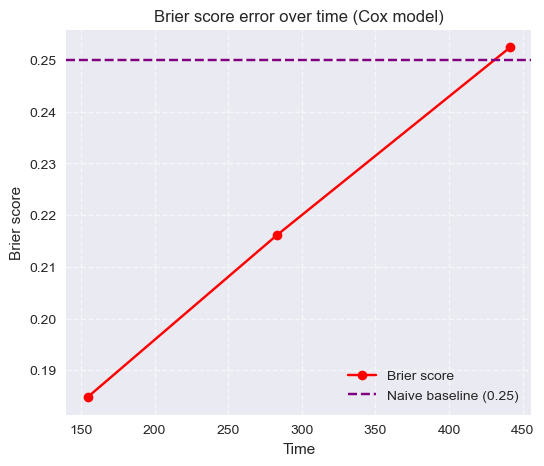

In [19]:
# Plot
plt.figure(figsize=(6, 5))
plt.plot(times_brier, brier_scores, marker="o", label="Brier score", color="red")
plt.axhline(y=0.25, color="purple", linestyle="--", label="Naive baseline (0.25)")
plt.xlabel("Time")
plt.ylabel("Brier score")
plt.title("Brier score error over time (Cox model)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

Calibration evaluated at t* = 283.0 days


/var/folders/j6/tp29chgj2bv5vvgk_cqxzsgm0000gn/T/ipykernel_52425/893251150.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration", color="red")


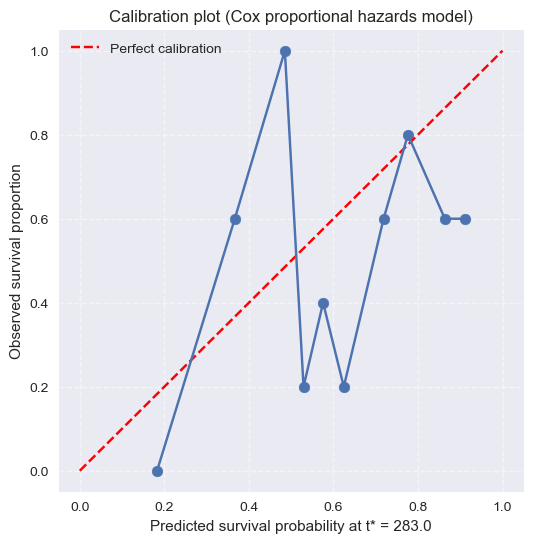

In [20]:
# Step 3 — Calibration plot
# ------------------------------------------------
# === Calibration plot ===
# Horizon temporel à évaluer (ex. médiane de la cohorte)
# Horizon temporel (ex. médiane)
t_star = np.median(test["time"])
print(f"Calibration evaluated at t* = {t_star:.1f} days")

# === 1. Predicted survival curves ===
# The model outputs a survival function for each individual in the test set.
# The resulting DataFrame has time points as rows and individuals as columns.
surv_df = cph.predict_survival_function(test)

# Interpolate survival probability at the chosen horizon t_star for each individual
pred_surv_t = np.array([
    np.interp(t_star, surv_df.index.values, surv_df[col].values)
    for col in surv_df.columns
])

# === 2. Observed outcomes ===
# Build a DataFrame that combines predicted survival probabilities with observed outcomes
df_calib = pd.DataFrame({
    "predicted": pred_surv_t,
    "status": test["status"],
    "time": test["time"]
})

# === 3. Binning (deciles) ===
# Divide individuals into 10 equally sized groups based on predicted probabilities
n_bins = 10
df_calib["bin"] = pd.qcut(df_calib["predicted"], q=n_bins, duplicates="drop")

# For each bin: compute the average predicted survival and observed survival proportion
calibration = df_calib.groupby("bin").apply(
    lambda d: pd.Series({
        "mean_pred": d["predicted"].mean(),
        "obs_surv": np.mean(d["time"] > t_star)
    })
).reset_index(drop=True)

# === 4. Calibration plot ===
# Compare predicted vs observed survival probabilities at time t*
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration", color="red")
plt.scatter(calibration["mean_pred"], calibration["obs_surv"], color="C0", s=60)
plt.plot(calibration["mean_pred"], calibration["obs_surv"], color="C0")
plt.xlabel(f"Predicted survival probability at t* = {t_star:.1f}")
plt.ylabel("Observed survival proportion")
plt.title("Calibration plot (Cox proportional hazards model)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

In [21]:
def calibration_error(calibration_df):
    """
    Compute the mean squared calibration error between predicted and observed survival.
    
    Parameters
    ----------
    calibration_df : pandas.DataFrame
        Must contain columns 'mean_pred' and 'obs_surv'.

    Returns
    -------
    float
        Mean squared error (MSE) between the calibration curve and the perfect line y = x.
    """
    mse = np.mean((calibration_df["mean_pred"] - calibration_df["obs_surv"]) ** 2)
    return np.sqrt(mse)

# Example usage
CE = calibration_error(calibration)
print(f"Calibration Error (distance to y=x): {CE:.4f}")

Calibration Error (distance to y=x): 0.2922


## 4. Compare Model-Based and Empirical Survival
We now compare the mean marginal survival predicted by the Cox model to the Kaplan–Meier estimate.

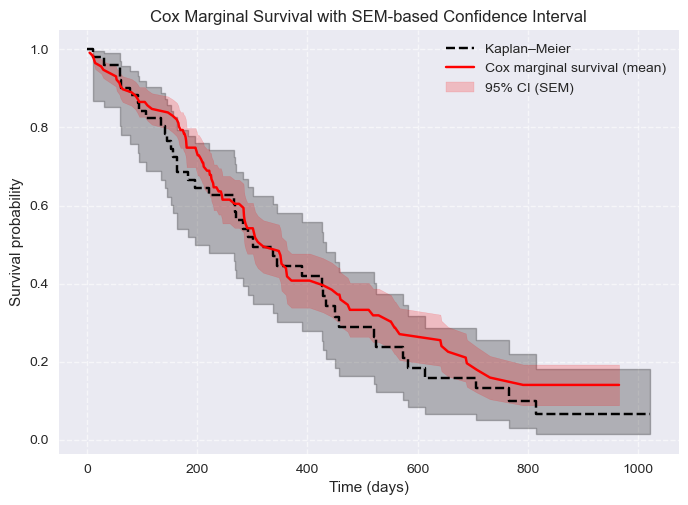

In [32]:
# Compute mean survival and SEM-based confidence intervals
mean_surv = surv_pred.mean(axis=1)
sem = surv_pred.std(axis=1) / np.sqrt(surv_pred.shape[1])  # SEM across individuals

z = 1.96  # for 95% CI
lower_ci = mean_surv - z * sem
upper_ci = mean_surv + z * sem

# Plot Kaplan–Meier
kmf.fit(test["time"], event_observed=test["status"], label="Kaplan–Meier")
ax = kmf.plot(ci_show=True, color="black", linestyle="--")

# Plot Cox mean survival and SEM-based CI
plt.plot(mean_surv.index, mean_surv.values, color="red", label="Cox marginal survival (mean)")
plt.fill_between(mean_surv.index, lower_ci.values, upper_ci.values,
                 color="red", alpha=0.2, label="95% CI (SEM)")

plt.title("Cox Marginal Survival with SEM-based Confidence Interval")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

In [33]:
from lifelines.statistics import logrank_test
from scipy.stats import ks_2samp

# === Significance threshold ===
alpha_value = 0.05

# === 1. Kolmogorov–Smirnov test ===
# We compare the two empirical survival distributions (Kaplan–Meier vs Cox)
ks_stat, ks_pvalue = ks_2samp(
    kmf.survival_function_.values.flatten(),
    mean_surv.values
)

print("Kolmogorov–Smirnov Test")
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4f}")
if ks_pvalue < alpha_value:
    print(f"→ Reject H0 at α={alpha_value}: the two survival distributions differ significantly.")
else:
    print(f"→ Fail to reject H0 at α={alpha_value}: no significant difference detected.")
print("-" * 70)

# === 2. Log-rank test ===
# For the log-rank test, we need to compare event times between two groups.
# Here we split individuals into "high" vs "low" predicted risk based on the median Cox risk score.
median_risk = cph.predict_partial_hazard(test).median()
group_high = test[cph.predict_partial_hazard(test) > median_risk]
group_low = test[cph.predict_partial_hazard(test) <= median_risk]

results_logrank = logrank_test(
    group_high["time"], group_low["time"],
    event_observed_A=group_high["status"],
    event_observed_B=group_low["status"]
)

print("Log-rank Test (High vs Low Cox risk)")
print(f"Test statistic: {results_logrank.test_statistic:.4f}, p-value: {results_logrank.p_value:.4f}")
if results_logrank.p_value < alpha_value:
    print(f"→ Reject H0 at α={alpha_value}: survival curves are significantly different.")
else:
    print(f"→ Fail to reject H0 at α={alpha_value}: no significant difference.")
print("-" * 70)

Kolmogorov–Smirnov Test
KS statistic: 0.1602, p-value: 0.3111
→ Fail to reject H0 at α=0.05: no significant difference detected.
----------------------------------------------------------------------
Log-rank Test (High vs Low Cox risk)
Test statistic: 1.0067, p-value: 0.3157
→ Fail to reject H0 at α=0.05: no significant difference.
----------------------------------------------------------------------


## 5. Summary
In this session, we:
- Estimated survival with Kaplan–Meier.
- Tested group differences using the log-rank test.
- Fitted a Cox proportional hazards model.
- Interpreted coefficients and hazard ratios.
- Compared empirical and model-based survival curves.